In [1]:
from typing import Iterable
from itertools import product
import string
import numpy as np
import socket
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

ASCII_CHARS = np.array(list(string.ascii_lowercase))
ASCII_CHARS

array(['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
       'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'],
      dtype='<U1')

In [2]:
def domain_generator(k: int, rng: np.random.Generator = None) -> Iterable[str]:
    if rng is None:
        rng = np.random.default_rng()
    
    generator_indexes = np.arange(k)
    random_char_generators = []
    remaining_domains = np.full(k, 26) ** np.arange(1, k+1)
    n_domains = np.sum(remaining_domains)
    for i in range(1, k+1):
            random_char_generators.append(
                product(*(rng.permutation(ASCII_CHARS) for _ in range(i)))
            )
    for _ in range(1, n_domains + 1):
        gen_idx = rng.choice(
            generator_indexes,
            p=remaining_domains / np.sum(remaining_domains)
        )
        remaining_domains[gen_idx] -= 1
        generator = random_char_generators[gen_idx]
        domain_name = next(generator)
        yield f'{domain_name}.ufrj.br'


def domain_exists(domain: str) -> bool:
    """
    Checks if a domain exists in the DNS.
    """
    try:
        # Checks if the domain exists by trying to resolve it
        # Raises socket.gaierror if the domain does not exist
        socket.getaddrinfo(domain, 0)
        return True
    except socket.gaierror:
        return False

def number_of_possible_domains(k: int) -> int:
    """
    Returns the number of possible domains with size <= k.
    """
    return np.sum(np.full(k, 26) ** np.arange(1, k+1))

In [3]:
def monte_calo_estimate(k: int, n: int, job_id: int) -> int:
    """
    Estimates the number of domains under the ufrj.br name of size <= k
    using Monte Carlo estimation.
    """
    print(f'{job_id} - Running monte carlo estimation for k={k} and n={n:.2E} ...')
    generator = domain_generator(k)
    n_domains = number_of_possible_domains(k)
    if n > n_domains:
        raise ValueError(f'n={n} is greater than the number of possible domains={n_domains}')
    number_estimate = 0
    for i_sample, domain_sample in enumerate(generator):
        if i_sample >= n:
            break
        if domain_exists(domain_sample):
            number_estimate += 1
    print(f'{job_id} - estimate={number_estimate}')
    return number_estimate

In [4]:
n_samples = np.logspace(1, 5, num=10, dtype=int)
job_pool = Parallel(n_jobs=-1)
k = 4
estimates = job_pool(
    delayed(monte_calo_estimate)(k, n, job_id)
    for job_id, n in enumerate(n_samples)
)

0 - Running monte carlo estimation for k=4 and n=1.00E+01 ...
0 - estimate=0
1 - Running monte carlo estimation for k=4 and n=2.70E+01 ...
1 - estimate=0
2 - Running monte carlo estimation for k=4 and n=7.70E+01 ...
2 - estimate=0
3 - Running monte carlo estimation for k=4 and n=2.15E+02 ...
3 - estimate=0
6 - Running monte carlo estimation for k=4 and n=4.64E+03 ...5 - Running monte carlo estimation for k=4 and n=1.67E+03 ...

4 - Running monte carlo estimation for k=4 and n=5.99E+02 ...
7 - Running monte carlo estimation for k=4 and n=1.29E+04 ...
8 - Running monte carlo estimation for k=4 and n=3.59E+04 ...
9 - Running monte carlo estimation for k=4 and n=1.00E+05 ...
4 - estimate=0
5 - estimate=0
6 - estimate=0
7 - estimate=0
8 - estimate=0
9 - estimate=0


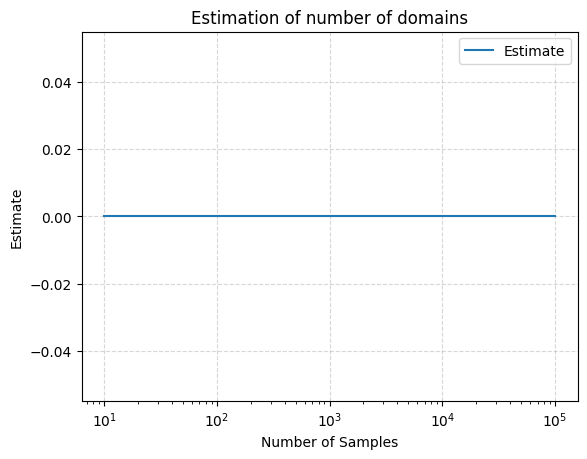

In [5]:
fig, ax = plt.subplots()
ax.grid(linestyle='--', alpha=0.5)
ax.plot(n_samples, estimates, label='Estimate')
# ax.axhline(np.e, label=f'Real Value: {np.e:.6f}', color='black', linestyle='--',)
ax.set_xlabel('Number of Samples')
ax.set_title('Estimation of number of domains')
# ax.set_ylabel('Integral Estimate')
ax.set_ylabel('Estimate')
ax.legend()
ax.set_xscale('log')